# Swiss LSTM Solar Forecast

**Author:** Jonas Henriksson  
**Description:** LSTM-based model for forecasting solar PV power output in Switzerland using ERA5 reanalysis data.  
**Environment:** Python 3.11.13

---

### Required libraries

In [132]:

from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import cdsapi
import zipfile
import tensorflow as tf #version 2.20.0 was used in this project
from tensorflow.keras import layers, models, callbacks, regularizers, optimizers, losses
# For scaled dot-product attention
from tensorflow.keras.layers import MultiHeadAttention
from tqdm.auto import tqdm

import os
os.environ["CDSAPI_URL"] = "https://cds.climate.copernicus.eu/api"



---
### Data retrieval: ERA5 features
#### Download parameters

In [133]:
# Edit these geographic and temporal parameters for your project
AREA = [47.9, 5.9, 45.8, 10.6]   # [N, W, S, E] coordinates, in this case for Switzerland
START   = "2021-10-01"              
END     = "2025-10-31"
POP_XYZ = r"che_pd_2020_1km_ASCII_XYZ.csv"  # your population CSV (X,Y,Z)
OUTDIR  = "era5_data"         # where to cache monthly downloads

ERA5_DOWNLOAD_FEATURES = [
        "surface_solar_radiation_downwards",
        "2m_temperature",
        "total_cloud_cover",
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "2m_dewpoint_temperature",
        "total_column_water_vapour",
        "low_cloud_cover", "medium_cloud_cover", "high_cloud_cover",  # lcc/mcc/hcc
        "mean_sea_level_pressure",
        "total_precipitation",            # tp   -> mm/h
        "convective_precipitation",       # cp   -> mm/h
        "boundary_layer_height",          # blh
        "snowfall","snow_depth"
    ]

SET_VAL_FRAC = 0.2 # Fraction of data set allocated for validation
VAL_WEEKS_SEED_NR = 43 # The seed ensures a reproducible random selection of weeks used for model validation. If changed, a different set of weeks will be used for validation.
# In order for model training to work properly, the mean and standard deviation of the training and validation set need to be similar. 
# The seed nr 43 renders a fairly similar mean and standard deviation between training and validation data sets. 


# ==============================================================================

#### Main and Helper Functions

In [134]:
# -----------------------------
# Helpers
# -----------------------------
def _ensure_iter(x):
    return x if isinstance(x, (list, tuple)) else [x]

def _open_cds_result(path):
    """
    Open a CDS result that may be a zip containing multiple .nc (instant/accum),
    trying multiple backends for robustness on Windows.
    """
    path = Path(path)

    def _open_one(p):
        # Try netCDF4 first (fast), then h5netcdf (portable), then scipy (if netCDF3)
        for eng in ("netcdf4", "h5netcdf", "scipy"):
            try:
                return xr.open_dataset(p, engine=eng)
            except Exception:
                pass
        raise RuntimeError(f"Could not open {p} with any engine")


    if zipfile.is_zipfile(path):
        with zipfile.ZipFile(path) as zf:
            nc_members = [n for n in zf.namelist() if n.endswith(".nc")]
            tmpdir = path.with_suffix("").as_posix() + "_parts"
            tmpdir = Path(tmpdir); tmpdir.mkdir(exist_ok=True)
            zf.extractall(tmpdir)

        dsets = []
        for n in nc_members:
            ds_i = _open_one(tmpdir / n)
            # fully load to detach file handles, then sanitize *before* combining
            ds_i.load()

            # promote valid_time to a coord if it arrived as a data var
            if "valid_time" in ds_i and "valid_time" not in ds_i.coords:
                ds_i = ds_i.set_coords("valid_time")

            # strip expver so it can't conflict across parts
            if "expver" in ds_i.dims:
                ds_i = ds_i.isel(expver=-1).drop_vars("expver", errors="ignore")
            elif "expver" in ds_i.coords or "expver" in ds_i.variables:
                ds_i = ds_i.drop_vars("expver", errors="ignore")

            dsets.append(ds_i)

        # be tolerant when combining multiple NetCDF parts from CDS
        ds = xr.combine_by_coords(
            dsets,
            combine_attrs="override",
            compat="override",
            data_vars="minimal",
            coords="minimal",
            join="outer",
        )
    else:
        ds = _open_one(path)
        ds.load()
        # strip expver here too, just in case
        if "expver" in ds.dims:
            ds = ds.isel(expver=-1).drop_vars("expver", errors="ignore")
        elif "expver" in ds.coords or "expver" in ds.variables:
            ds = ds.drop_vars("expver", errors="ignore")

    return ds

def _ensure_single_time_coord(ds: xr.Dataset) -> xr.Dataset:
    has_time = "time" in ds.coords
    has_valid = "valid_time" in ds.coords

    if has_time and has_valid:
        # if they’re identical, drop the duplicate
        try:
            same = xr.DataArray(
                ds["time"].astype("datetime64[ns]").values
            ).equals(
                xr.DataArray(ds["valid_time"].astype("datetime64[ns]").values)
            )
        except Exception:
            same = False
        if same:
            ds = ds.drop_vars("valid_time")
        else:
            # prefer valid_time as the physical timestamp for fluxes, rename to 'time'
            ds = ds.drop_vars("time", errors="ignore").rename({"valid_time": "time"})

    elif has_valid and not has_time:
        ds = ds.rename({"valid_time": "time"})

    # Ensure it’s sorted and actually a coordinate
    if "time" in ds.coords:
        ds = ds.sortby("time")

    # Sanity: NetCDF path should NOT have 'step'
    if "step" in ds.dims:
        raise ValueError("Dataset has a 'step' dimension. You likely downloaded GRIB; "
                         "for GRIB you must compute valid_time=time+step and diff accumulations.")

    return ds

def _derive_wind(ds):
    if {"u10","v10"}.issubset(ds):
        u, v = ds["u10"], ds["v10"]
        speed = np.hypot(u, v)
        wd    = (np.degrees(np.arctan2(-u, -v)) % 360.0)  # 0°=N, 90°=E

        # circular encoding
        wd_rad = np.deg2rad(wd)
        ds["wind_speed_10m"] = speed.astype("float32")
        ds["wind_dir_10m"]   = wd.astype("float32")
        ds["wind_dir_x"]     = np.cos(wd_rad).astype("float32")
        ds["wind_dir_y"]     = np.sin(wd_rad).astype("float32")

        ds["wind_speed_10m"].attrs |= {"units":"m s-1","long_name":"10 m wind speed"}
        ds["wind_dir_10m"].attrs   |= {"units":"degrees","long_name":"10 m wind direction (meteorological)"}
        ds["wind_dir_x"].attrs     |= {"long_name":"cos(wind_dir_10m)"}
        ds["wind_dir_y"].attrs     |= {"long_name":"sin(wind_dir_10m)"}
    return ds

def _convert_units(ds):
    # Temperature K -> °C
    if "t2m" in ds:
        ds["t2m_c"] = ds["t2m"] - 273.15
        ds["t2m_c"].attrs |= {"units":"°C","long_name":"2 m air temperature"}
    # Cloud cover 0..1 -> %
    if "tcc" in ds:
        ds["tcc_pct"] = ds["tcc"] * 100.0
        ds["tcc_pct"].attrs |= {"units":"%","long_name":"total cloud cover"}
    # Accumulated shortwave J/m2 per hour -> mean W/m2
    if "ssrd" in ds:
        ds["ssrd_wm2"] = ds["ssrd"] / 3600.0
        ds["ssrd_wm2"].attrs |= {"units":"W m-2","long_name":"surface solar radiation downwards (mean over hour)"}
    return ds

def _solar_zenith_approx(lat_deg, lon_deg, times):
    """
    Fast solar zenith (deg) for a single (lat, lon) over many times.
    times: array-like of datetimes; DatetimeIndex or Series is fine.
    Interprets naive times as UTC; converts tz-aware to UTC.
    """
    ts = pd.DatetimeIndex(times)
    ts = ts.tz_localize("UTC") if ts.tz is None else ts.tz_convert("UTC")

    # Day of year & fractional year (gamma)
    n = ts.dayofyear.values
    gamma = 2*np.pi*(n - 1)/365.0

    # Declination (rad)
    dec = (0.006918
           - 0.399912*np.cos(gamma)
           + 0.070257*np.sin(gamma)
           - 0.006758*np.cos(2*gamma)
           + 0.000907*np.sin(2*gamma)
           - 0.002697*np.cos(3*gamma)
           + 0.001480*np.sin(3*gamma))

    # Equation of time (minutes)
    E = 229.18*(0.000075
                + 0.001868*np.cos(gamma)
                - 0.032077*np.sin(gamma)
                - 0.014615*np.cos(2*gamma)
                - 0.040849*np.sin(2*gamma))

    # Local solar time (hours) offset for longitude
    h = ts.hour.values + ts.minute.values/60 + ts.second.values/3600
    lst = h + (E/60.0) + (lon_deg/15.0)

    # Hour angle (rad)
    H = np.radians(15.0*(lst - 12.0))

    # Zenith
    latr = np.radians(lat_deg)
    cos_zen = np.sin(latr)*np.sin(dec) + np.cos(latr)*np.cos(dec)*np.cos(H)
    cos_zen = np.clip(cos_zen, -1.0, 1.0)
    return np.degrees(np.arccos(cos_zen))

def _haurwitz_clear_sky_ghi(lat, lon, times_utc):
    """
    Haurwitz clear-sky GHI (W/m2): GHI = 1098 * cos(z) * exp(-0.057 / cos(z)), cos(z)>0 else 0.
    """
    zen = _solar_zenith_approx(lat, lon, times_utc)
    mu = np.cos(np.radians(zen))
    ghi = 1098.0 * np.maximum(mu, 0) * np.exp(-0.057 / np.maximum(mu, 1e-6))
    ghi[mu <= 0] = 0.0
    return ghi

def _to_utc(t):
    """Return a UTC tz-aware pandas Timestamp for any input."""
    ts = pd.to_datetime(t)
    return ts.tz_localize("UTC") if ts.tz is None else ts.tz_convert("UTC")

def _to_hours_range(start, end):
    """Build CDS lists (year, month, day, time) from an hourly range [UTC]."""
    start = _to_utc(start)
    end   = _to_utc(end)
    rng = pd.date_range(start, end, freq="H", inclusive="both")
    years  = sorted({f"{d.year:04d}" for d in rng})
    months = sorted({f"{d.month:02d}" for d in rng})
    days   = sorted({f"{d.day:02d}" for d in rng})
    times  = sorted({f"{d.hour:02d}:00" for d in rng})
    return years, months, days, times

def _strip_expver(ds: xr.Dataset) -> xr.Dataset:
    # If expver is a dimension, pick the last slice (newest) then drop it.
    if "expver" in ds.dims:
        ds = ds.isel(expver=-1)
        ds = ds.drop_vars("expver", errors="ignore")
    # If expver is a coord/var, just drop it.
    elif "expver" in ds.coords or "expver" in ds.variables:
        ds = ds.drop_vars("expver", errors="ignore")
    return ds


def _preprocess_era5(ds):
    # drop/pin expver everywhere
    if "expver" in ds.dims:
        ds = ds.isel(expver=-1).drop_vars("expver", errors="ignore")
    elif "expver" in ds.coords or "expver" in ds.variables:
        ds = ds.drop_vars("expver", errors="ignore")

    # promote valid_time to coord if needed
    if "valid_time" in ds and "valid_time" not in ds.coords:
        ds = ds.set_coords("valid_time")

    # normalize to a single 'time' coord
    if "valid_time" in ds.coords and "time" in ds.coords:
        try:
            same = np.array_equal(
                ds["time"].astype("datetime64[ns]").values,
                ds["valid_time"].astype("datetime64[ns]").values,
            )
        except Exception:
            same = False
        if same:
            ds = ds.drop_vars("valid_time")
        else:
            ds = ds.drop_vars("time", errors="ignore").rename({"valid_time": "time"})
    elif "valid_time" in ds.coords and "time" not in ds.coords:
        ds = ds.rename({"valid_time": "time"})

    if "time" in ds.coords:
        ds = ds.sortby("time")

    return ds

# -----------------------------
# Main function data retrieval function
# -----------------------------
def era5_download(
    start, end,
    variables,
    area=None,                 # [N, W, S, E] or None for global
    product="reanalysis-era5-single-levels",
    target="era5.nc",
    point=None,                # (lat, lon) -> return nearest grid point as pandas DataFrame
    derive=True,               # add °C, %, W/m2, wind speed/dir
    clear_sky=None             # None | "haurwitz" -> adds ghi_clear and clear-sky index k*
):
    """
    Download ERA5 hourly data from CDS for a date range and variable list.
    - start/end: 'YYYY-MM-DD' or any pandas-compatible datetime (interpreted as UTC)
    - variables: list of ERA5 variable IDs (e.g., '2m_temperature','total_cloud_cover','surface_solar_radiation_downwards','10m_u_component_of_wind','10m_v_component_of_wind')
    - area: [N, W, S, E] in degrees
    - product: dataset short name (default: ERA5 single levels)
    - target: output file path
    - point: (lat, lon) to select nearest grid cell and return a tidy pandas DataFrame
    - derive: add common derived variables and unit conversions
    - clear_sky: if "haurwitz", compute crude clear-sky GHI at 'point' (or center of area) and k* = GHI/clear
    Returns:
      - xarray.Dataset if point is None
      - pandas.DataFrame (time-indexed) if point is provided
    """
    # Build CDS time fields
    years, months, days, times = _to_hours_range(start, end)

    req = {
        "product_type": "reanalysis",
        "format": "netcdf",
        "variable": _ensure_iter(variables),
        "year": years,
        "month": months,
        "day": days,
        "time": times,
    }
    if area is not None:
        req["area"] = area  # [N, W, S, E]

    c = cdsapi.Client()
    c.retrieve(product, req, target)

    ds = _open_cds_result(target)
    ds = _ensure_single_time_coord(ds)
    ds = _strip_expver(ds)

    # ERA5 time is UTC
    if "time" in ds.coords:
        ds = ds.sortby("time")

    # Common derivations / units
    if derive:
        ds = _convert_units(ds)
        ds = _derive_wind(ds)

    # If user asks for a single point, select nearest grid cell and return DataFrame
    if point is not None:
        lat0, lon0 = float(point[0]), float(point[1])
        # ERA5 longitudes can be 0..360; normalize lon0 accordingly
        if ds.longitude.max() > 180:
            lon0 = (lon0 + 360) % 360
        
        pt = ds.sel(latitude=lat0, longitude=lon0, method="nearest")
        tname = "time" if "time" in pt.coords else ("valid_time" if "valid_time" in pt.coords else None)
        if tname is None:
            raise KeyError("No time/valid_time coord found in ERA5 dataset")
        df = (pt.to_dataframe().reset_index().set_index(tname).sort_index())

        # Optional clear-sky using Haurwitz (very rough, no external services)
        if clear_sky == "haurwitz":
            # choose evaluation coordinates
            plat = float(pt["latitude"].values)
            plon = float(pt["longitude"].values if "longitude" in pt.coords else lon0)
            if plon > 180:
                plon = plon - 360  # back to –180…+180
            
            times_utc = df.index.tz_localize("UTC") if df.index.tz is None else df.index
            ghi_cs = _haurwitz_clear_sky_ghi(plat, plon, times_utc)
            df["ghi_clear_haurwitz"] = ghi_cs
            # pick measured GHI proxy if present
            if "ssrd_wm2" in df:
                df["k_star"] = (df["ssrd_wm2"] / df["ghi_clear_haurwitz"]).clip(upper=2.0)
            elif "ssrd" in df:
                df["k_star"] = ((df["ssrd"]/3600.0) / df["ghi_clear_haurwitz"]).clip(upper=2.0)
        return df
    return ds


# -----------------------------
# Monthly chunker (avoids request error CDS 403)
# -----------------------------
def era5_download_monthly(start, end, *, variables, area=None, derive=True,
                          product="reanalysis-era5-single-levels",
                          out_dir=".", prefix="era5_CH"):
    start_utc = _to_utc(start)
    end_utc   = _to_utc(end)

    # first of the start month at 00:00 UTC
    cur = start_utc.replace(day=1, hour=0, minute=0, second=0, microsecond=0)

    paths = []
    while cur <= end_utc:
        # end-of-month at 23:00 UTC (hourly data)
        month_end = (cur + pd.offsets.MonthEnd(0)).replace(hour=23, minute=0, second=0, microsecond=0)

        m_start = max(start_utc, cur)
        m_end   = min(end_utc,   month_end)

        target = Path(out_dir) / f"{prefix}_{cur.year}-{cur.month:02d}.nc"
        if not target.exists():
            ds_m = era5_download(
                start=m_start, end=m_end,
                variables=variables, area=area,
                product=product, target=str(target),
                derive=derive
            )
            # Optional: compact save
            enc = {v: {"dtype": "float32"} for v in ds_m.data_vars}
            ds_m.astype({v: "float32" for v in ds_m.data_vars}).to_netcdf(target, engine="scipy", encoding=enc)
            try: ds_m.close()
            except Exception: pass

        paths.append(str(target))
        cur = (cur + pd.offsets.MonthBegin(1))

    ds_all = xr.open_mfdataset(
    paths,
    combine="by_coords",
    data_vars="minimal",
    coords="minimal",
    compat="override",
    preprocess=_preprocess_era5,
    ).sortby("time")

    # De-dup any overlapping timestamps just in case
    if "time" in ds_all.coords:
        ds_all = ds_all.sel(time=~ds_all.get_index("time").duplicated())

    return ds_all


#### Data retrieval call

In [135]:
#For a large dataset, this will take hours to complete.
ds_all = era5_download_monthly(
    start=START, end=END,
    variables=ERA5_DOWNLOAD_FEATURES,
    area=AREA,
    out_dir=OUTDIR,
    derive=True
)

### Solar Power Data Retrieval
Solar power generation data can be downloaded by year from ENTSO-e Transparancy Platform on:
https://iop-transparency.entsoe.eu/

The data files covering Switzerland 2021-2025 are included on the GitHub directory.

In [136]:
def read_entsoe_solar_hourly(path: str) -> pd.Series:
    """
    Read an ENTSO-E 'Actual Generation per Production Type' CSV and return
    an hourly UTC Series of Swiss Solar generation [MW].
    """
    df = pd.read_csv(path, sep=None, engine="python")
    df.columns = [c.strip() for c in df.columns]

    # Keep Switzerland rows (Bidding Zone CH)
    if "Area" in df.columns:
        df = df[df["Area"].astype(str).str.contains(r"\bBZN\|CH\b|\bCH\b", regex=True, na=False)].copy()

    # Parse MTU left bound (local CH time) → UTC index
    left_local = df["MTU"].astype(str).str.split(" - ").str[0]
    dt_local = pd.to_datetime(left_local, dayfirst=True, format="%d.%m.%Y %H:%M", errors="coerce")
    idx_local = pd.DatetimeIndex(dt_local).tz_localize(
        "Europe/Zurich",
        nonexistent="shift_forward",  # DST spring gap
        ambiguous="infer",            # DST fall overlap
    )
    idx_utc = idx_local.tz_convert("UTC")
    df["time_utc"] = idx_utc

    # Find the Solar aggregated column
    # It typically looks like: "Solar - Actual Aggregated [MW]"
    solar_cols = [c for c in df.columns if c.startswith("Solar - Actual ") and "Aggregated" in c]
    if not solar_cols:
        raise KeyError("Could not find 'Solar - Actual Aggregated [MW]' column.")
    solar_col = solar_cols[0]

    # Clean numbers (turn 'n/e' into NaN)
    df[solar_col] = pd.to_numeric(df[solar_col].replace({"n/e": np.nan, "": np.nan, " ": np.nan}), errors="coerce")

    # Build Series (UTC), drop NaT/dupes, sort
    s = df.set_index("time_utc")[solar_col].sort_index()
    s = s[~s.index.isna()]
    s = s[~s.index.duplicated(keep="first")]
    s.name = "Solar"
    return s


In [137]:
y_2025 = read_entsoe_solar_hourly(
    r"EnergyData/Actual Generation per Production Type_202501010000-202601010000.csv"
)
y_2024 = read_entsoe_solar_hourly(
    r"EnergyData/Actual Generation per Production Type_202401010000-202501010000.csv"
)
y_2023 = read_entsoe_solar_hourly(
    r"EnergyData/Actual Generation per Production Type_202301010000-202401010000.csv"
)
y_2022 = read_entsoe_solar_hourly(
    r"EnergyData/Actual Generation per Production Type_202201010000-202301010000.csv"
)
y_2021 = read_entsoe_solar_hourly(
    r"EnergyData/Actual Generation per Production Type_202101010000-202201010000.csv"
)

# Concatenate to a single hourly UTC series
y_solar = pd.concat([y_2021, y_2022, y_2023, y_2024, y_2025]).sort_index()
# Optional: keep unique index in case of overlaps
y_solar = y_solar[~y_solar.index.duplicated(keep="first")]

---
#### Data Exploration

In [138]:
# Plotting of Solar Radiation, Cloud Cover and Wind Speed
def _find_time_coord(da):
    """Return the name of a datetime-like coord in da (prefers 'time', then 'valid_time')."""
    # Prefer common names first
    for name in ("time", "valid_time"):
        if name in da.coords and np.issubdtype(da.coords[name].dtype, np.datetime64):
            return name
    # Otherwise search any datetime64 (or cftime-like) coord
    for name, coord in da.coords.items():
        if np.issubdtype(coord.dtype, np.datetime64):
            return name
        if getattr(coord, "dtype", None) is None and hasattr(coord, "data"):
            try:
                if getattr(coord.data, "dtype", None) and "cftime" in str(type(coord.data[0])).lower():
                    return name
            except Exception:
                pass
    raise KeyError("No datetime-like coordinate found on DataArray.")

def _normalize_lon_for_ds(ds, lon):
    lon = float(lon)
    if "longitude" in ds.coords and ds.longitude.max() > 180:
        return (lon + 360.0) % 360.0  # map to 0..360
    return lon  # leave as -180..180

def _to_time_1d(da):
    """Return (times_utc, values) ensuring a single datetime coord exists (handles 'valid_time')."""
    da = da.squeeze(drop=True)
    tname = _find_time_coord(da)
    # Drop any non-time dims by taking the first index (e.g., expver, step)
    for dim in list(da.dims):
        if dim == tname:
            continue
        if dim == "step":
            raise ValueError(
                "Found 'step' dimension—this looks like GRIB accumulations. "
                "Compute valid_time=time+step and convert accumulations first."
            )
        da = da.isel({dim: 0})

        # if dim != tname:
        #     da = da.isel({dim: 0})
    # Standardize to 'time'
    if tname != "time":
        da = da.rename({tname: "time"})
    times = pd.DatetimeIndex(da["time"].values)  # UTC in ERA5
    vals = np.asarray(da.values)
    return times, vals

def plot_era5_point(ds, lat=47.3769, lon=8.5417, tz="Europe/Zurich"):
    # Select nearest grid cell
    lon = _normalize_lon_for_ds(ds, lon)
    pt = ds.sel(latitude=lat, longitude=lon, method="nearest").squeeze(drop=True)
    # If an extra expver dim exists, slice it away early
    # if "expver" in getattr(pt, "dims", {}):
    #     pt = pt.isel(expver=0)
    if "expver" in pt.dims:
        pt = pt.isel(expver=-1)  # prefer newest

    # GHI (W/m²)
    if "ssrd_wm2" in pt.data_vars:
        ghi_da = pt["ssrd_wm2"]
    elif "ssrd" in pt.data_vars:
        ghi_da = pt["ssrd"] / 3600.0
        ghi_da.name = "ssrd_wm2"
    else:
        raise KeyError("Neither 'ssrd_wm2' nor 'ssrd' found in dataset.")

    # Total cloud cover (%)
    if "tcc_pct" in pt.data_vars:
        tcc_da = pt["tcc_pct"].clip(0, 100)
    elif "tcc" in pt.data_vars:
        tcc_da = (pt["tcc"] * 100.0).clip(0, 100)
        tcc_da.name = "tcc_pct"
    tcc_da.attrs |= {"units": "%", "long_name": "total cloud cover"}

    # Wind speed (m/s)
    if "wind_speed_10m" in pt.data_vars:
        wspd_da = pt["wind_speed_10m"]
    elif {"u10", "v10"}.issubset(set(pt.data_vars)):
        wspd_da = np.hypot(pt["u10"], pt["v10"])
        wspd_da.name = "wind_speed_10m"
    else:
        raise KeyError("No wind variables found ('wind_speed_10m' or 'u10'/'v10').")
    
    # Make sure all three series share the same time stamps
    ghi_da, tcc_da, wspd_da = xr.align(ghi_da, tcc_da, wspd_da, join="inner")

    # Extract time/value pairs (handles 'valid_time' transparently)
    t_ghi, v_ghi = _to_time_1d(ghi_da)
    t_tcc, v_tcc = _to_time_1d(tcc_da)
    t_w,   v_w   = _to_time_1d(wspd_da)

    # Localize/convert for nice labels (only if naive)
    if t_ghi.tz is None:
        t_ghi = t_ghi.tz_localize("UTC").tz_convert(tz)
        t_tcc = t_tcc.tz_localize("UTC").tz_convert(tz)
        t_w   = t_w.tz_localize("UTC").tz_convert(tz)

    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(t_ghi, v_ghi)
    axes[0].set_ylabel("W/m²")
    axes[0].set_title("ERA5 – Surface solar radiation (nearest to Zürich)")

    axes[1].plot(t_tcc, v_tcc)
    axes[1].set_ylabel("%")
    axes[1].set_title("Total cloud cover")

    axes[2].plot(t_w, v_w)
    axes[2].set_ylabel("m/s")
    axes[2].set_title("10 m wind speed")

    axes[-1].set_xlabel(f"Time ({tz})")
    fig.tight_layout()
    plt.show()


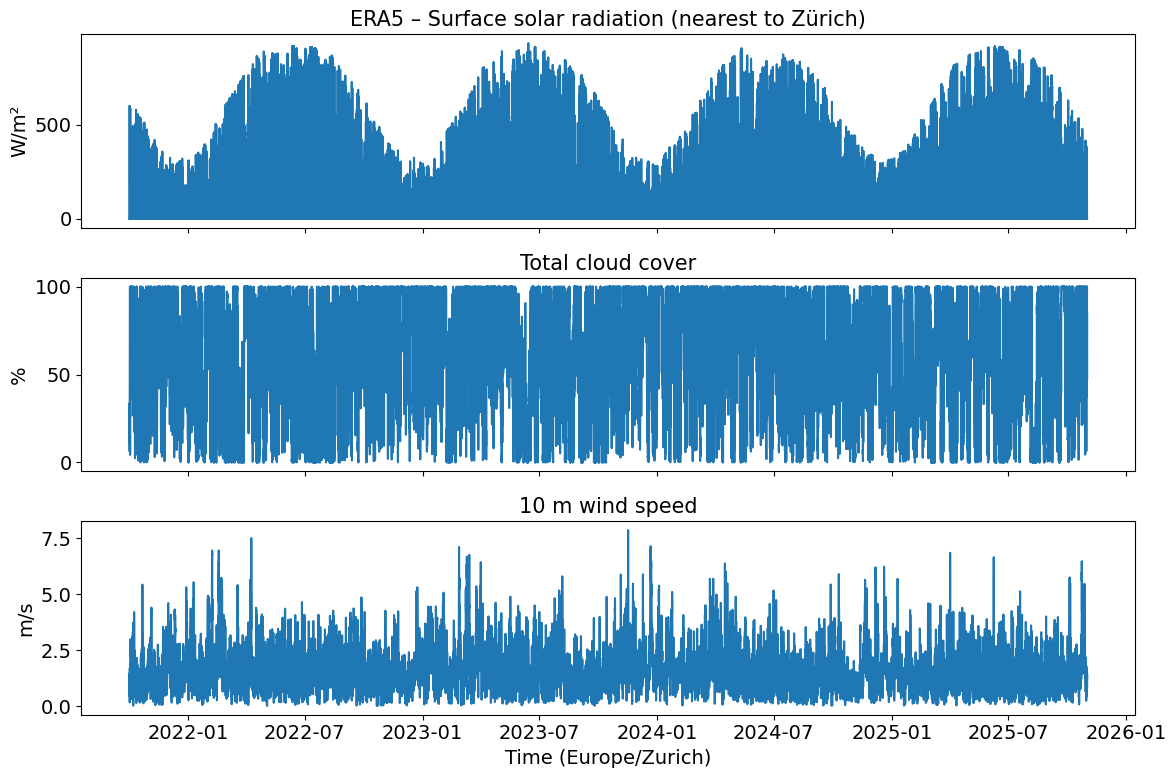

In [139]:
plot_era5_point(ds_all)

### Data preprocessing
#### Population density correction
Assuming that solar panels are approximatively distributed where there are people living, the impact of each parameter is weighted according to a population density grid.

In [140]:
# If you do not wish to apply population density weighting, this section should be commented out.

# ---- inputs ----
csv_path = Path(POP_XYZ)  # update path if needed

# ---- pick irradiance (W/m²) ----
ghi = ds_all["ssrd_wm2"] if "ssrd_wm2" in ds_all else ds_all["ssrd"] / 3600.0

# find ERA5 time coord name
tname = "time" if "time" in ghi.coords else ("valid_time" if "valid_time" in ghi.coords else None)
if tname is None:
    raise KeyError("No time/valid_time coord found in ERA5 dataset")

# take a single time slice as spatial template
tmpl = ghi.isel({tname: 0})

# ERA5 coords (note: latitude is usually **descending**)
lats = tmpl["latitude"].values
lons = tmpl["longitude"].values

# Build bin edges from ERA5 centers (handles irregular step if any)
def _edges_from_centers(centers):
    centers = np.asarray(centers)
    # if descending, flip, build edges, then flip back
    flipped = False
    if centers[0] > centers[-1]:
        centers = centers[::-1]
        flipped = True
    d = np.diff(centers)
    # assume last step equals median of diffs (robust)
    step = np.median(d)
    edges = np.concatenate(([centers[0] - step/2], centers[:-1] + d/2, [centers[-1] + step/2]))
    if flipped:
        edges = edges[::-1]
    return edges

lat_edges = _edges_from_centers(lats)
lon_edges = _edges_from_centers(lons)

# ---- read the XYZ CSV (X=lon, Y=lat, Z=pop density) ----
usecols = ["X", "Y", "Z"]
df = pd.read_csv(csv_path, usecols=usecols)

# optional: clip to ERA5 bbox to speed up binning
lat_min, lat_max = lat_edges.min(), lat_edges.max()
lon_min, lon_max = lon_edges.min(), lon_edges.max()
df = df[(df["Y"] >= min(lat_min, lat_max)) & (df["Y"] <= max(lat_min, lat_max)) &
        (df["X"] >= min(lon_min, lon_max)) & (df["X"] <= max(lon_min, lon_max))]

# ---- bin the points into ERA5 cells ----
# np.digitize returns 1..N for N bins; subtract 1 to get 0..N-1
lat_idx = np.digitize(df["Y"].values, lat_edges) - 1
lon_idx = np.digitize(df["X"].values, lon_edges) - 1

# keep only indices inside grid
valid = (lat_idx >= 0) & (lat_idx < len(lats)) & (lon_idx >= 0) & (lon_idx < len(lons))
lat_idx = lat_idx[valid]
lon_idx = lon_idx[valid]
vals    = df["Z"].values[valid]  # population density ~ people per ~1km²

# aggregate: sum density ~ approx population proxy per ERA5 cell
pop_grid = np.zeros((len(lats), len(lons)), dtype="float64")
# Beware: ERA5 lat order may be descending; our indices align to lats as given
np.add.at(pop_grid, (lat_idx, lon_idx), vals)

# ---- build weights DataArray aligned with ERA5 ----
weights = xr.DataArray(
    pop_grid,
    coords={"latitude": lats, "longitude": lons},
    dims=("latitude", "longitude"),
)

# zero negatives/NaNs, mask where GHI is NaN (outside CH bbox if any)
weights = xr.where(weights > 0, weights, 0.0)
weights = weights.where(np.isfinite(tmpl), 0.0)

# normalize to sum to 1 across Switzerland
w_sum = weights.sum(dim=("latitude", "longitude"))
weights_norm = xr.where(w_sum > 0, weights / w_sum, 0.0)

# ---- compute weighted vs area-mean GHI (hourly) ----
ghi_weighted = (ghi * weights_norm).sum(dim=("latitude", "longitude"))
ghi_area     = ghi.mean(dim=("latitude", "longitude"), skipna=True)

# (optional) temperature derate using pop-weighted Tair
if "t2m" in ds_all:
    tair_c = ds_all["t2m"] - 273.15
    tair_weighted = (tair_c * weights_norm).sum(dim=("latitude","longitude"))
    Tmod = tair_weighted + (45 - 20)/800.0 * ghi_weighted  # NOCT≈45°C
    eta_temp = (1.0 + (-0.004) * (Tmod - 25.0)).clip(min=0.0)
    ghi_weighted_eff = (ghi_weighted * eta_temp).clip(min=0.0)
else:
    ghi_weighted_eff = ghi_weighted



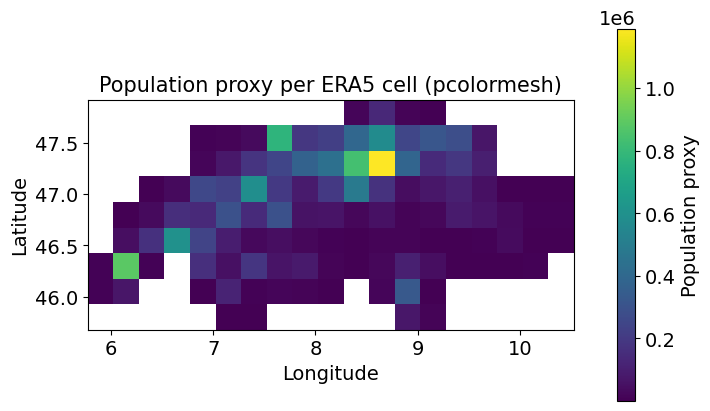

In [141]:
# If you do not wish to apply population density weighting, this section should be commented out.

fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)

# mask zeros for nicer contrast (optional)
pop_plot = pop_grid.copy()
pop_plot[pop_plot <= 0] = np.nan

pc = ax.pcolormesh(lon_edges, lat_edges, pop_plot, shading="auto")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.set_title("Population proxy per ERA5 cell (pcolormesh)")
ax.set_aspect("equal")

cb = fig.colorbar(pc, ax=ax)          # colorbar sized to the axes height
cb.set_label("Population proxy")

plt.show()


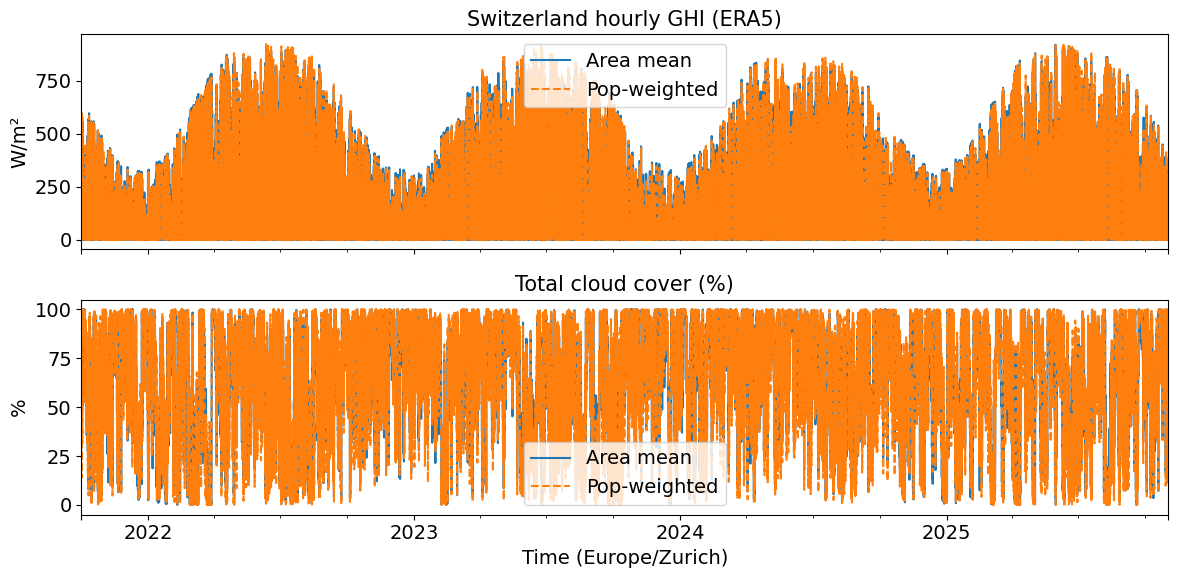

In [142]:
# If you do not wish to apply population density weighting, this section should be commented out.

# --- Cloud cover (%), area-mean vs population-weighted ---
tcc = ds_all["tcc_pct"] if "tcc_pct" in ds_all else ds_all["tcc"] * 100.0

tcc_area     = tcc.mean(dim=("latitude","longitude"), skipna=True)
tcc_weighted = (tcc * weights_norm).sum(dim=("latitude","longitude"))

# Convert both GHI and TCC to pandas (and to local time for nicer axes)
ghi_area_s      = ghi_area.to_pandas()
ghi_weighted_s  = ghi_weighted.to_pandas()
tcc_area_s      = tcc_area.to_pandas()
tcc_weighted_s  = tcc_weighted.to_pandas()

for s in (ghi_area_s, ghi_weighted_s, tcc_area_s, tcc_weighted_s):
    if s.index.tz is None:
        s.index = s.index.tz_localize("UTC").tz_convert("Europe/Zurich")

# --- Plot: GHI on top, Cloud cover below ---
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Top: GHI
ghi_area_s.plot(ax=axes[0], label="Area mean")
ghi_weighted_s.plot(ax=axes[0], label="Pop-weighted", linestyle="--")
axes[0].set_title("Switzerland hourly GHI (ERA5)")
axes[0].set_ylabel("W/m²")
axes[0].legend()

# Bottom: Cloud cover
tcc_area_s.plot(ax=axes[1], label="Area mean")
tcc_weighted_s.plot(ax=axes[1], label="Pop-weighted", linestyle="--")
axes[1].set_title("Total cloud cover (%)")
axes[1].set_ylabel("%")
axes[1].set_xlabel("Time (Europe/Zurich)")
axes[1].legend()

plt.tight_layout()
plt.show()


### Snow layer state

In [143]:
# optional convenience fields
ds_all["sf_mmph"] = ds_all["sf"] * 1000.0      # mm/hour
ds_all["sd_mm"]   = ds_all["sd"] * 1000.0      # mm


In [144]:
def compute_snow_state_fast(
    ds,
    alpha=0.92,     # persistence
    k_acc=0.02,     # snowfall -> accumulation gain (per mm)
    k_melt=0.015,   # melt from warm sun
    k_wind=0.010,   # wind shedding
    ghi_ref=600.0,  # W/m² scaling
    sd_init_thresh=5.0,  # mm threshold to seed snow at t0
    progress=True,
) -> xr.DataArray:
    """
    Returns snow_state in [0,1] with dims (time, latitude, longitude).
    Uses fast NumPy frame-wise updates and an optional tqdm progress bar.
    """

    # Ensure needed fields exist and align
    g = ds["ssrd_wm2"].transpose("time", "latitude", "longitude")
    t = (ds["t2m_c"] if "t2m_c" in ds else ds["t2m"] - 273.15).transpose("time","latitude","longitude")
    if "wind_speed_10m" in ds:
        w = ds["wind_speed_10m"].transpose("time","latitude","longitude")
    else:
        w = np.hypot(ds["u10"], ds["v10"]).transpose("time","latitude","longitude")

    # Snowfall rate: mm/h
    if "sf_mmph" in ds:
        sf = ds["sf_mmph"].transpose("time","latitude","longitude")         # already mm/h
        SF = sf
    elif "sf" in ds:
        sf = ds["sf"].transpose("time","latitude","longitude")              # m/h
        SF = sf * 1000.0                                             # -> mm/h
    else:
        raise KeyError("Need 'sf_mmph' or 'sf' in dataset to compute snow_state")
    
    sd0 = (ds["sd"] if "sd" in ds else ds["sd_mm"]/1000.0).isel(time=0).transpose("latitude","longitude")

    # Bring to NumPy arrays (small domain so memory is fine)
    G = np.nan_to_num(g.values, copy=False)
    T = np.nan_to_num(t.values, copy=False)
    W = np.nan_to_num((w.values if isinstance(w, xr.DataArray) else w), copy=False)
    SF = np.nan_to_num(SF.values, copy=False)
    SD0 = np.nan_to_num(sd0.values, copy=False)

    Tlen, Y, X = G.shape
    S = np.zeros((Tlen, Y, X), dtype=np.float32)

    # Seed from initial snow depth (mm)
    S[0] = (SD0 * 1000.0 > sd_init_thresh).astype(np.float32)

    rng = range(1, Tlen)
    if progress:
        rng = tqdm(rng, total=Tlen-1, desc="snow_state")

    # Frame-wise recurrence
    for i in rng:
        #acc  = k_acc  * (SF[i] * 1000.0)  # convert m -> mm
        acc = k_acc * SF[i]
        melt = k_melt * np.where(T[i] > 0, T[i] * np.clip(G[i] / ghi_ref, 0.0, 2.0), 0.0)
        shed = k_wind * W[i]
        S[i] = np.clip(alpha * S[i-1] + acc - melt - shed, 0.0, 1.0)

    snow_state = xr.DataArray(
        S,
        coords=dict(time=ds.time, latitude=ds.latitude, longitude=ds.longitude),
        dims=("time","latitude","longitude"),
        name="snow_state",
        attrs={"long_name":"heuristic snow cover state", "units":"1"},
    )
    return snow_state


In [145]:
snow_state = compute_snow_state_fast(ds_all, progress=True)
ds_all["snow_state"] = snow_state


snow_state: 100%|██████████| 35807/35807 [00:00<00:00, 57239.17it/s]


#### Solar Zenith and Clear-Sky Irradiance Features

In [146]:

# ds_all dims: time, latitude, longitude
lat2d, lon2d = xr.broadcast(ds_all["latitude"], ds_all["longitude"])

# vectorized solar-zenith on the ERA5 grid, reusing your helpers
def _mu0_from_latlon_times(lat_deg, lon_deg, times_utc):
    # times_utc: pandas.DatetimeIndex (UTC)
    # returns: np.array shape (T,) of mu0 = cos(zenith) clipped to [0,1]
    zen = _solar_zenith_approx(lat_deg, lon_deg, times_utc)  
    mu0 = np.cos(np.deg2rad(zen))
    mu0[mu0 < 0] = 0.0
    return mu0

times_utc = pd.DatetimeIndex(ds_all["time"].values).tz_localize("UTC")

# compute mu0 for each grid cell (171 cells => fast enough in Python)
mu_list = []
for j in range(lat2d.shape[0]):        # over latitude index
    row = []
    for i in range(lon2d.shape[1]):    # over longitude index
        mu = _mu0_from_latlon_times(float(lat2d[j, i]), float(lon2d[j, i]), times_utc)
        row.append(mu)
    mu_list.append(np.stack(row, axis=1))  # (T, lon)
mu0 = np.stack(mu_list, axis=1)            # (T, lat, lon)

ds_all["mu0"] = (("time","latitude","longitude"), mu0.astype("float32"))
ds_all["mu0"].attrs.update(units="", long_name="cosine of solar zenith angle")

# Optional: clear-sky GHI (Haurwitz) and clear-sky index
def _haurwitz_mu(mu):
    mu_safe = np.maximum(mu, 1e-6)
    ghi = 1098.0 * np.maximum(mu, 0.0) * np.exp(-0.057 / mu_safe)
    return ghi

ghi_clear = _haurwitz_mu(mu0).astype("float32")
ds_all["ghi_clear"] = (("time","latitude","longitude"), ghi_clear)
ds_all["ghi_clear"].attrs.update(units="W m-2", long_name="Haurwitz clear-sky GHI")

if "ssrd_wm2" in ds_all:
    kstar = (ds_all["ssrd_wm2"] / ds_all["ghi_clear"]).clip(min=0.0, max=2.0)
    ds_all["kstar"] = kstar.fillna(0.0).astype("float32")
    ds_all["kstar"].attrs.update(long_name="clear-sky index", units="")

In [147]:
# Vectorized over all times & grid cells
t_utc = pd.DatetimeIndex(ds_all.time.values).tz_localize("UTC")
n = t_utc.dayofyear.values
gamma = 2*np.pi*(n - 1)/365.0

dec = (0.006918
       - 0.399912*np.cos(gamma)
       + 0.070257*np.sin(gamma)
       - 0.006758*np.cos(2*gamma)
       + 0.000907*np.sin(2*gamma)
       - 0.002697*np.cos(3*gamma)
       + 0.001480*np.sin(3*gamma))

E = 229.18*(0.000075 + 0.001868*np.cos(gamma) - 0.032077*np.sin(gamma)
            - 0.014615*np.cos(2*gamma) - 0.040849*np.sin(2*gamma))
h = t_utc.hour.values + t_utc.minute.values/60 + t_utc.second.values/3600
H0 = np.radians(15.0*(h + E/60.0 - 12.0))

lat = np.deg2rad(ds_all.latitude.values)      # (Lat,)
lon = np.deg2rad(ds_all.longitude.values)     # (Lon,)

sin_lat = np.sin(lat)[None, :, None]
cos_lat = np.cos(lat)[None, :, None]
sin_dec = np.sin(dec)[:, None, None]
cos_dec = np.cos(dec)[:, None, None]
H = H0[:, None, None] + lon[None, None, :]

sin_elev = sin_lat*sin_dec + cos_lat*cos_dec*np.cos(H)
sin_elev = np.clip(sin_elev, -1.0, 1.0)
elev = np.arcsin(sin_elev)

cos_elev = np.clip(np.cos(elev), 1e-8, None)
denom_lat = np.clip(cos_lat, 1e-8, None)

sin_az = -np.sin(H)*cos_dec/cos_elev
cos_az = (sin_dec - sin_elev*sin_lat) / (cos_elev*denom_lat)
az = (np.degrees(np.arctan2(sin_az, cos_az)) % 360.0).astype("float32")

# Sun vector components
sx = (np.cos(elev)*np.sin(np.deg2rad(az))).astype("float32")
sy = (np.cos(elev)*np.cos(np.deg2rad(az))).astype("float32")
sz = (np.sin(elev)).astype("float32")

# Optional μ0 and Haurwitz clear sky
mu0 = np.clip(sin_elev, 0.0, 1.0).astype("float32")
ghi_clear = (1098.0 * mu0 * np.exp(-0.057/np.maximum(mu0, 1e-6))).astype("float32")

# Attach to ds_all
ds_all["sun_azimuth"] = (("time","latitude","longitude"), az)
ds_all["sun_x"] = (("time","latitude","longitude"), sx)
ds_all["sun_y"] = (("time","latitude","longitude"), sy)
ds_all["sun_z"] = (("time","latitude","longitude"), sz)
ds_all["mu0"] = (("time","latitude","longitude"), mu0)
ds_all["ghi_clear"] = (("time","latitude","longitude"), ghi_clear)


In [148]:
# μ0 already computed: shape (time, lat, lon), in [0,1]
daymask = (ds_all["mu0"] > 0).astype("float32")

for comp in ["sun_x", "sun_y", "sun_z"]:
    if comp in ds_all:
        ds_all[comp] = (ds_all[comp] * daymask).astype("float32")


#### Solar Power Capacity Factor Development
The data on solar power capacity was derived from data from Ember, accessible on https://ember-energy.org/data/

The data set is also included in the GitHub directory.

In [149]:
# #  Read & make a monthly Series (Date -> index, pick Value)

xlsx = r"ember_energy_data/SolarPowerPerMonth_Ember.xlsx"

# Read & make a monthly Series (Date -> index, pick Value)
E_month = (
    pd.read_excel(xlsx)
      .assign(Date=lambda df: pd.to_datetime(df["Date"]))
      .set_index("Date")["Value"]
      .asfreq("MS")
)

In [150]:
# ---- clear-sky envelope (scalar over CH) ----
if "ghi_clear" in ds_all:
    Iclr = ds_all["ghi_clear"].mean(("latitude","longitude")).to_pandas()
else:
    mu0 = ds_all["mu0"].mean(("latitude","longitude")).to_pandas()
    Iclr = 1098.0 * mu0 * np.exp(-0.057/np.maximum(mu0, 1e-6))
    Iclr[mu0 <= 0] = 0.0

<Axes: >

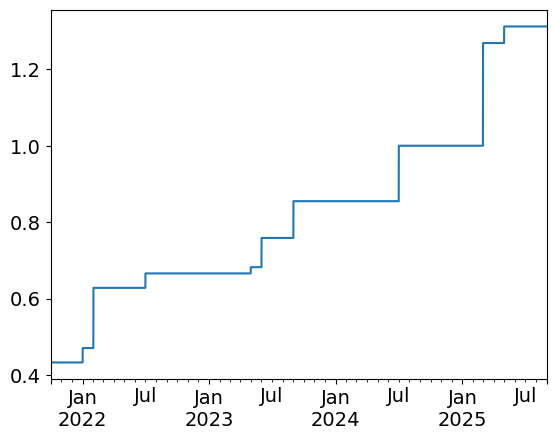

In [151]:

# build monthly clear-sky index from your hourly dataset
# Iclr_hourly: area-mean clear-sky GHI (e.g., W/m2), Pandas hourly index (UTC, same as y)

Iclr_month = Iclr.resample("MS").sum(min_count=1)  # monthly sum (relative index)

# 3) Align on the intersection of dates and divide
E_aln, I_aln = E_month.align(Iclr_month, join='inner')  # index align by time
cap_proxy = (E_aln / I_aln).dropna()

# smooth + enforce non-decreasing if desired
cap_proxy = cap_proxy.rolling(3, min_periods=1, center=True).median()
#cap_proxy = cap_proxy.cummax()  # optional

# choose a stable summer month (e.g. July 2024) as reference
ref = cap_proxy.loc['2024-07-01']
cap_scale_month = cap_proxy / ref

# enforce non-decreasing only if you truly want a capacity trend
cap_scale_month = np.maximum.accumulate(cap_scale_month)

# convert to hourly for downstream use
cap_scale_hourly = cap_scale_month.resample("h").ffill()

cap_scale_hourly.plot()



Linear fit: slope=0.000000/day, R²=0.903


C:\Users\jonhe\AppData\Local\Temp\ipykernel_170740\1007810051.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  cap_scale_hourly_new = cap_scale_month_new.resample("H").interpolate(method='linear')


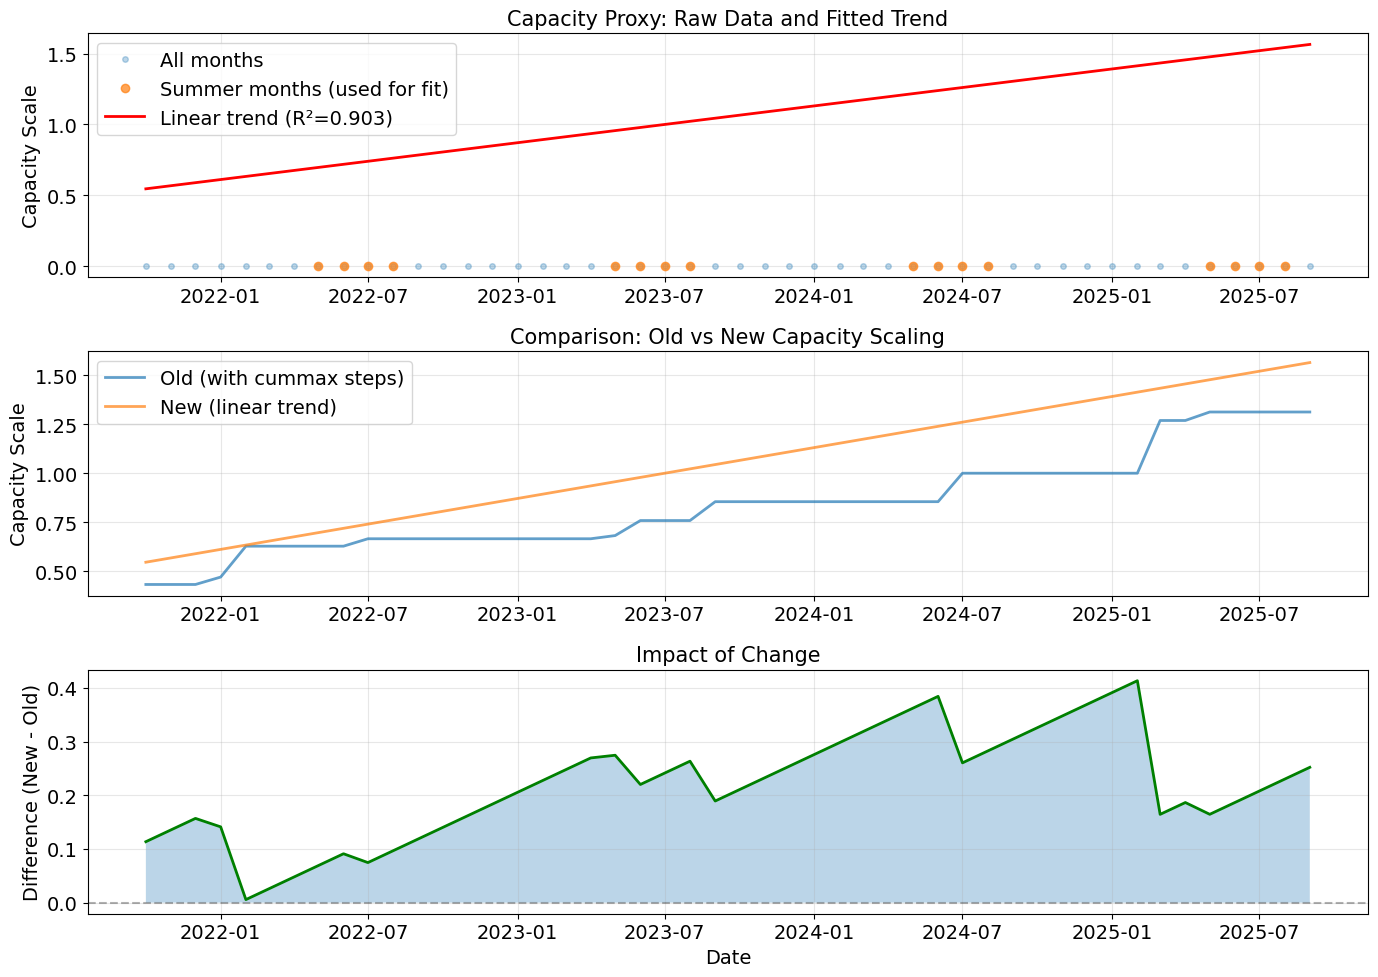


=== Capacity Values at Key Dates ===
Date         Old      New      Diff    
------------------------------------
2024-06        0.855    1.239   +0.384
2024-07        1.000    1.260   +0.260
2024-08        1.000    1.282   +0.282
2024-09        1.000    1.304   +0.304

=== Expected Impact ===
If August 2024 had capacity=0.896 (old) but should be ~1.1 (new),
then predictions were scaled by: 0.896 / 1.100 = 0.81× too low
This would explain ~23% underprediction!


In [152]:
# For a smoother behavior, a linear fit is made to approximate the deployment of added solar power

# Only use May-August for capacity estimation (best conditions)
summer_months = [5, 6, 7, 8]
cap_proxy_reliable = cap_proxy[cap_proxy.index.month.isin(summer_months)]

# Fit a linear trend through summer months only
from scipy import stats

# Get numeric timestamps for regression
x_numeric = (cap_proxy_reliable.index - cap_proxy_reliable.index[0]).days.values
y_values = cap_proxy_reliable.values

slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, y_values)

print(f"Linear fit: slope={slope:.6f}/day, R²={r_value**2:.3f}")

# Extrapolate to all months
all_days = (cap_scale_month.index - cap_proxy_reliable.index[0]).days.values
cap_trend = intercept + slope * all_days

# Normalize by July 2023 or June 2024 (pick a good reference)
ref_date = pd.Timestamp('2023-07-01')

# Find closest date in index
closest_idx = cap_scale_month.index.get_indexer([ref_date], method='nearest')[0]
ref_value = cap_trend[closest_idx]

cap_scale_month_new = pd.Series(cap_trend / ref_value, index=cap_scale_month.index)

# Don't use cummax - use the smoothed trend
cap_scale_hourly_new = cap_scale_month_new.resample("H").interpolate(method='linear')

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Raw capacity proxy with fitted trend
axes[0].plot(cap_proxy.index, cap_proxy.values, 'o', alpha=0.3, label='All months', markersize=4)
axes[0].plot(cap_proxy_reliable.index, cap_proxy_reliable.values, 'o', 
             alpha=0.7, label='Summer months (used for fit)', markersize=6)
axes[0].plot(cap_scale_month.index, cap_trend / ref_value, 
             'r-', linewidth=2, label=f'Linear trend (R²={r_value**2:.3f})')
axes[0].legend()
axes[0].set_ylabel('Capacity Scale')
axes[0].set_title('Capacity Proxy: Raw Data and Fitted Trend')
axes[0].grid(True, alpha=0.3)

# Plot 2: Old vs new
axes[1].plot(cap_scale_month.index, cap_scale_month.values, 
             label='Old (with cummax steps)', linewidth=2, alpha=0.7)
axes[1].plot(cap_scale_month_new.index, cap_scale_month_new.values, 
             label='New (linear trend)', linewidth=2, alpha=0.7)
axes[1].legend()
axes[1].set_ylabel('Capacity Scale')
axes[1].set_title('Comparison: Old vs New Capacity Scaling')
axes[1].grid(True, alpha=0.3)

# Plot 3: Difference
diff = cap_scale_month_new.values - cap_scale_month.values
axes[2].plot(cap_scale_month.index, diff, 'g-', linewidth=2)
axes[2].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[2].fill_between(cap_scale_month.index, 0, diff, alpha=0.3)
axes[2].set_ylabel('Difference (New - Old)')
axes[2].set_xlabel('Date')
axes[2].set_title('Impact of Change')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show key differences
print("\n=== Capacity Values at Key Dates ===")
key_dates = pd.to_datetime(['2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01'])
print(f"{'Date':<12} {'Old':<8} {'New':<8} {'Diff':<8}")
print("-" * 36)
for date in key_dates:
    if date in cap_scale_month.index:
        idx = cap_scale_month.index.get_indexer([date], method='nearest')[0]
        old_val = cap_scale_month.iloc[idx]
        new_val = cap_scale_month_new.iloc[idx]
        print(f"{date.strftime('%Y-%m'):<12} {old_val:>7.3f}  {new_val:>7.3f}  {new_val-old_val:>+7.3f}")

# Check if this would fix the August 2024 problem
print("\n=== Expected Impact ===")
print("If August 2024 had capacity=0.896 (old) but should be ~1.1 (new),")
print(f"then predictions were scaled by: {0.896:.3f} / {1.1:.3f} = {0.896/1.1:.2f}× too low")
print(f"This would explain ~{(1.1/0.896 - 1)*100:.0f}% underprediction!")

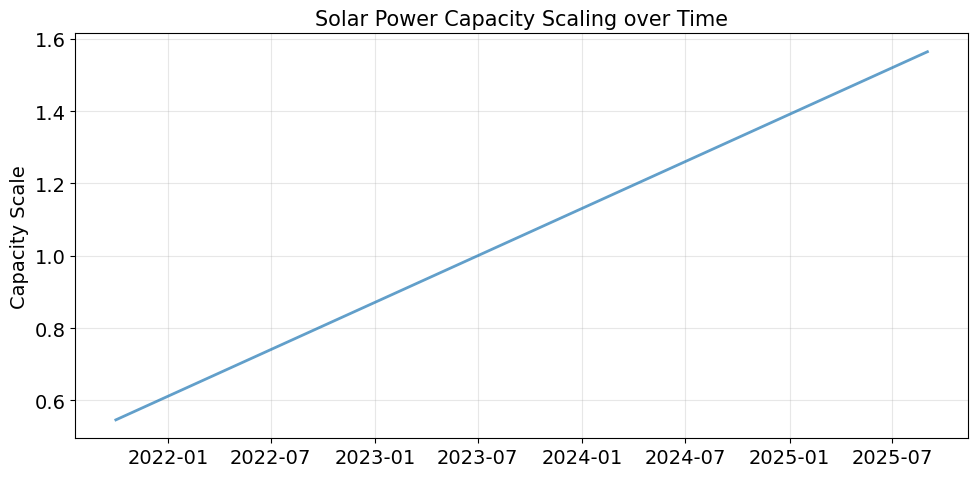

In [153]:

plt.rcParams.update({
    'font.size': 14,          # base font size (was typically 10)
    'axes.titlesize': 15,     # title
    'axes.labelsize': 14,     # x/y labels
    'legend.fontsize': 14,    # legend
    'xtick.labelsize': 14,    # x-ticks
    'ytick.labelsize': 14,    # y-ticks
})

# Plot comparison
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

axes.plot(cap_scale_month_new.index, cap_scale_month_new.values, 
             linewidth=2, alpha=0.7)

axes.set_ylabel('Capacity Scale')
axes.set_title('Solar Power Capacity Scaling over Time')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [154]:
cap_scale_month = cap_scale_month_new

In [155]:
t_era = ds_all.indexes["time"]       
cap_scale_hourly = cap_scale_hourly.reindex(t_era).ffill().bfill()      # cover edges
cap_scale_hourly.name = "cap_scale"

#### Population density weighting of relevant features

In [156]:
features_to_weight = [
    "t2m_c", "tcc_pct", "t2m", "tcc",
    "ssrd_wm2",
    "wind_speed_10m", 'u10', 'v10',
    "sf_mmph", "sd_mm", "snow_state", "sf", "sd",
    "mu0", 
    'd2m', 'tcwv',  #total_column_water_vapour
    'lcc', 'mcc', 'hcc', # "low_cloud_cover", "medium_cloud_cover", "high_cloud_cover"
    'msl', 'blh', 'tp', 'cp' #mean_sea_level_pressure, boundary_layer_height, total_precipitation, convective_precipitation
]

# Population-weighted mean for each feature
def weighted_mean(ds, var, weights):
    return (ds[var] * weights).sum(dim=("latitude","longitude")) / weights.sum()

X = xr.Dataset({
    v: weighted_mean(ds_all, v, weights_norm)
    for v in features_to_weight
})
X = X.to_dataframe()


#### Data reformating in spatiotemporal sequences

In [157]:

# add wind_dir_x/y from wind_dir_10m if available
if "wind_dir_10m" in ds_all:
    wd = np.deg2rad(ds_all["wind_dir_10m"])
    ds_all = ds_all.assign(
        wind_dir_x=np.cos(wd).astype("float32"),
        wind_dir_y=np.sin(wd).astype("float32"),
    )

#Features that will be used in model
features = [
    "t2m_c", "tcc_pct", "ssrd_wm2",
    "wind_speed_10m", "wind_dir_x", "wind_dir_y",
    "sf_mmph", "snow_state",
    "mu0",
    "sun_x", "sun_y", "sun_z",
    "d2m", "tcwv",
    "lcc", "mcc", "hcc",
    "msl", "blh", "tp", "cp",
]


# sanity
missing = [f for f in features if f not in ds_all]
if missing:
    raise KeyError(f"Missing in ds_all: {missing}")

# -----------------------------
# 2) Build 4D feature tensor X: (time, lat, lon, channel)
# -----------------------------
X = xr.concat(
    [ds_all[f].astype("float32") for f in features],
    dim=xr.DataArray(features, dims="channel", name="channel"),
).transpose("time", "latitude", "longitude", "channel")

# -----------------------------
# 3) Align & clean PV target (UTC-naive to match ds_all.time)
# -----------------------------
t_era = ds_all.indexes["time"]  # keeps order

pv = y_solar.copy()
if pv.index.tz is not None:
    pv.index = pv.index.tz_convert("UTC").tz_localize(None)

# put PV on the ERA5 timeline (no sorting)
y = pv.reindex(t_era).astype(float)

# Night = 0 (using max mu0 over CH); small daytime gaps -> interpolate
mu0_area = ds_all["mu0"].max(("latitude", "longitude")).to_pandas()
night = mu0_area <= 0
y.loc[night] = 0.0
day = ~night
y.loc[day] = y.loc[day].interpolate(limit=2)
y = y.bfill(limit=1).ffill(limit=1)

# final mask: keep finite targets
mask = np.isfinite(y.values)

# apply the same mask to X without sorting (indexes are aligned)
X = X.isel(time=np.where(mask)[0])
y = y[mask]

# -----------------------------
# 4) Train/val split by time and STANDARDIZE (train-only stats)
# -----------------------------
lag = 24        # hours of history
horizon = 6     # forecast horizon
train_frac = 0.8

T = X.sizes["time"]
split = int(T * train_frac)

X_train = X.isel(time=slice(0, split))

# per-channel mean/std over time+space from TRAIN only
ch_mean = X_train.mean(dim=("time", "latitude", "longitude"), skipna=True)
ch_std  = X_train.std (dim=("time", "latitude", "longitude"), skipna=True)
ch_std  = xr.where(ch_std < 1e-6, 1.0, ch_std)

# standardize all data with train stats; fill residual NaNs with 0 (z=0)
X_z = ((X - ch_mean) / ch_std).fillna(0.0)

# scale y too (optional but helps NN stability)
y_train = y.iloc[:split]
y_mean  = float(y_train.mean())
y_std   = float(y_train.std()) if y_train.std() > 1e-6 else 1.0
y_z     = (y - y_mean) / y_std


# ---- capacity scale -> hourly -> align -> mask -> standardize (train only) ----
# cap_scale_month: monthly (MS) Series you built earlier, normalized ~1.0…1.3

# 1) hourly step function and align to ds_all timeline
cap_hr = cap_scale_month.resample("h").ffill()
cap_hr = cap_hr.reindex(ds_all.indexes["time"]).ffill().bfill()   # cover edges

# 2) apply the SAME time mask you used for X and y (no sorting!)
mask_idx = np.where(mask)[0]
cap_aligned = pd.Series(cap_hr.values, index=ds_all.indexes["time"]).iloc[mask_idx]
cap_aligned.name = "cap_scale"

# 3) standardize on TRAIN only (like you do for y and channels)
cap_train = cap_aligned.iloc[:split]
# cap_std   = float(cap_train.std()) if cap_train.std() > 1e-6 else 1.0
# cap_z     = (cap_aligned - cap_mean) / cap_std
cap_mean = float(cap_train.mean())
cap_pos  = cap_aligned / max(cap_mean, 1e-6)   # ~1.0, strictly >0


# ---- Absolute capacity (MW), aligned to y, train-only anchored ----
# Choose a sunny reference month that lies in TRAIN; keep it simple:
ref_month = "2024-07" if (y.index.strftime("%Y-%m") == "2024-07").any() else y.index[:split][0].strftime("%Y-%m")

# robust near-peak MW in that month (avoid dawn/dusk)
mu0_area_aln = mu0_area.reindex(y.index).fillna(0.0)
ref_mask = (y.index.strftime("%Y-%m") == ref_month) & (mu0_area_aln > 0.2)
p99 = float(np.nanpercentile(y.loc[ref_mask], 99)) if ref_mask.any() else float(np.nanpercentile(y.iloc[:split], 99))

CF_PEAK = 0.95  # assume 95% peak CF in July-ish
C_REF_MW = p99 / CF_PEAK

# capacity scale already aligned and masked above: cap_aligned (dimensionless)
cap_abs = (C_REF_MW * cap_aligned.astype("float32"))  # pandas Series (MW), index == y.index


# -----------------------------
# 5) Make spatiotemporal sequences
# -----------------------------
def make_spatiotemporal_sequences(DA_std: xr.DataArray,
                                  y_series: pd.Series,
                                  cap_abs_series: pd.Series,
                                  cap_norm_series: pd.Series,  # ← ADD THIS
                                  lag=24, horizon=6):
    X_np   = DA_std.values                     # (T, H, W, C)
    y_np   = y_series.values.astype("float32") # (T,)
    A_abs  = cap_abs_series.values.astype("float32")   # (T,) MW
    A_norm = cap_norm_series.values.astype("float32")  # (T,) normalized ~0.5-1.5

    T = X_np.shape[0]
    X_list, y_list, A_abs_list, A_norm_list = [], [], [], []
    for t0 in range(0, T - lag - horizon):
        X_list.append(X_np[t0:t0+lag, ...])                # (lag, H, W, C)
        tgt = t0 + lag + horizon
        y_list.append(y_np[tgt])                           # scalar, z(MW)
        A_abs_list.append(A_abs[tgt])                      # MW at target
        A_norm_list.append(A_norm[tgt])                    # normalized at target
    return (np.asarray(X_list, np.float32),
            np.asarray(y_list, np.float32),
            np.asarray(A_abs_list, np.float32)[:, None],   # (N,1) MW
            np.asarray(A_norm_list, np.float32)[:, None])  # (N,1) normalized


X_seq, y_seq, A_abs_seq, A_norm_seq = make_spatiotemporal_sequences(
    X_z, y_z, cap_abs, cap_aligned,  # ← cap_aligned is your 0.5-1.5 scale
    lag=lag, horizon=horizon
)
print("X_seq:", X_seq.shape)
print("y_seq:", y_seq.shape)
print("A_abs_seq:", A_abs_seq.shape, f"range: {A_abs_seq.min():.0f}-{A_abs_seq.max():.0f} MW")
print("A_norm_seq:", A_norm_seq.shape, f"range: {A_norm_seq.min():.3f}-{A_norm_seq.max():.3f}")

# save scalers for inverse-transform later
scalers = {
    "x_channel_names": list(X.coords["channel"].values),
    "x_mean": ch_mean.values,   # (channels,)
    "x_std":  ch_std.values,    # (channels,)
    "y_mean": y_mean,
    "y_std":  y_std,
}

X_seq: (35646, 24, 9, 19, 21)
y_seq: (35646,)
A_abs_seq: (35646, 1) range: 1954-5596 MW
A_norm_seq: (35646, 1) range: 0.546-1.564


#### Splitting into training, validation and purge weeks

In [158]:

# --- 1) Target timestamps for each sequence (length = X_seq.shape[0]) ---
idx_full = pd.DatetimeIndex(X.indexes["time"])          # post-mask ERA5/PV index
seq_target_times = idx_full[(lag + horizon):(lag + horizon + X_seq.shape[0])]

# --- 2) Group by calendar week, sample ~20% of weeks for validation, purge ±1 week ---
weeks = seq_target_times.to_period("W-SUN")
unique_weeks = weeks.unique()

rng = np.random.default_rng(VAL_WEEKS_SEED_NR)

#rng = np.random.default_rng(43)
val_frac = SET_VAL_FRAC
n_blocks = max(1, int(len(unique_weeks) * val_frac / 2))
val_weeks_seed = rng.choice(unique_weeks, size=n_blocks, replace=False)

val_weeks = set(val_weeks_seed)
purge_weeks = set()

# for w in val_weeks_seed:
#     purge_weeks.add(w - 1)
#     purge_weeks.add(w + 1)

for w in val_weeks_seed:
    purge_weeks.add(w - 1)
    #val_weeks.add(w)
    val_weeks.add(w + 1)
    purge_weeks.add(w + 2)


# --- NEW STEP: remove purge weeks that sit between two val weeks --- This means that the train / validation dataset fraction will not be completely equal to the set value.
# --- Promote enclosed purge runs to validation ---
all_weeks_sorted = np.array(sorted(unique_weeks))

val_set   = set(val_weeks)
purge_set = set(purge_weeks)

i = 0
while i < len(all_weeks_sorted):
    w = all_weeks_sorted[i]

    # Skip non-purge weeks
    if w not in purge_set:
        i += 1
        continue

    # Start of a contiguous purge run
    start = i
    while i < len(all_weeks_sorted) and all_weeks_sorted[i] in purge_set:
        i += 1
    end = i - 1

    left_idx  = start - 1
    right_idx = i

    # If the run is enclosed by validation weeks, promote it
    if (
        left_idx >= 0
        and right_idx < len(all_weeks_sorted)
        and all_weeks_sorted[left_idx] in val_set
        and all_weeks_sorted[right_idx] in val_set
    ):
        for j in range(start, i):
            wj = all_weeks_sorted[j]
            purge_set.remove(wj)
            val_set.add(wj)

# Iteratively promote until stable
changed = True
while changed:
    changed = False
    for w in list(purge_set):
        left_is_val = (w - 1) in val_set
        right_is_val = (w + 1) in val_set
        if left_is_val and right_is_val:
            purge_set.remove(w)
            val_set.add(w)
            changed = True

# write back
val_weeks = val_set
purge_weeks = purge_set


is_val   = pd.Series(weeks.isin(val_weeks),   index=seq_target_times)
is_purge = pd.Series(weeks.isin(purge_weeks), index=seq_target_times) & ~is_val
is_train = ~is_val & ~is_purge

print("weeks total:", len(unique_weeks),
      "| val weeks:", sum(is_val.groupby(weeks).any()),
      "| purged seq:", int(is_purge.sum()))

# --- 3) Apply to sequences (include capacity!) ---
X_tr, y_tr, A_norm_tr, A_abs_tr = X_seq[is_train.values], y_seq[is_train.values], A_norm_seq[is_train.values], A_abs_seq[is_train.values]
X_va, y_va, A_norm_va, A_abs_va = X_seq[is_val.values],   y_seq[is_val.values],  A_norm_seq[is_val.values], A_abs_seq[is_val.values]
val_times        = seq_target_times[is_val.values]

print("train:", X_tr.shape, y_tr.shape, A_norm_tr.shape,
      "| val:", X_va.shape, y_va.shape, A_norm_va.shape)


weeks total: 214 | val weeks: 42 | purged seq: 5712
train: (22878, 24, 9, 19, 21) (22878,) (22878, 1) | val: (7056, 24, 9, 19, 21) (7056,) (7056, 1)


In [159]:
print("Train mean PV:", (y_tr * scalers["y_std"] + scalers["y_mean"]).mean(),
      "Val mean PV:", (y_va * scalers["y_std"] + scalers["y_mean"]).mean())


Train mean PV: 461.82477 Val mean PV: 419.09692


In [160]:
print("Train standard deviation PV:", (y_tr * scalers["y_std"] + scalers["y_mean"]).std(),
      "Val standard deviation PV:", (y_va * scalers["y_std"] + scalers["y_mean"]).std())

Train standard deviation PV: 783.57434 Val standard deviation PV: 721.3159


In [161]:
t = seq_target_times  # DatetimeIndex, UTC

# Bring in hour and time of the year as inputs
# build at seq_target_times
hour = t.hour.to_numpy()
doy  = t.dayofyear.to_numpy()
H = np.c_[np.sin(2*np.pi*hour/24), np.cos(2*np.pi*hour/24),
          np.sin(2*np.pi*doy/365.25), np.cos(2*np.pi*doy/365.25)].astype("float32")
H_tr = H[is_train.values]; H_va = H[is_val.values]



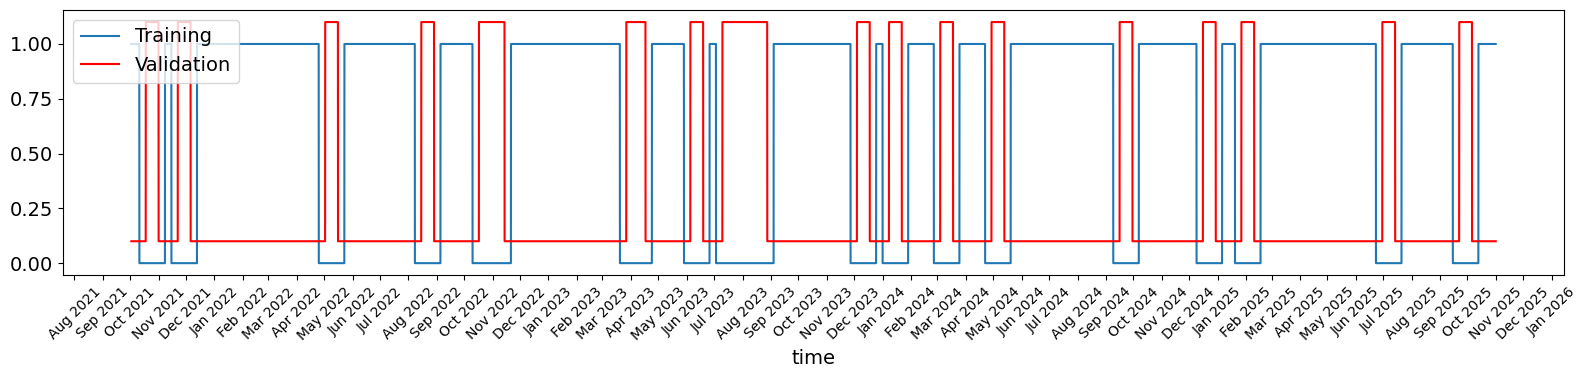

In [162]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(16,4))   
sns.lineplot(ax=ax, x=is_train.index, y=is_train.values, label='Training')
sns.lineplot(ax=ax, x=is_train.index, y=is_val.values+0.1, c='r', label='Validation')

# Put a tick every month and format it
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))       # every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))       # e.g., "Jan 2025"

plt.xticks(rotation=45, size=10)  # or 30, 60, etc.

plt.legend( loc="upper left")
plt.tight_layout()
plt.show()

#### Training weights definition to focus model training on daytime

In [163]:
# 0) Choose your twilight ramp (tune as you like)
TWILIGHT_LO, TWILIGHT_SPAN = 0.02, 0.15   # start lifting weights at mu=0.02, reach 1 by 0.17

# 1) Per-time μ (cos zenith) over Switzerland (mean over lat/lon)
#    If ds_all is dask-backed, this remains lazy until .to_series()/.compute()
mu0_series = ds_all["mu0"].mean(dim=("latitude","longitude")).to_series()  # index = ds_all.time

# 2) Grab μ at those target times and convert to weights
mu0_target = mu0_series.reindex(seq_target_times)   # pandas aligns by timestamp
mu0_target = np.asarray(mu0_target.values, dtype="float32")

w_all = np.clip((mu0_target - TWILIGHT_LO) / TWILIGHT_SPAN, 0.1, 1.0).astype("float32") #strongly downweigh importance of night-time prediction

# 3) Split weights with the same masks you already created
w_tr = w_all[is_train.values]
# Usually keep validation unweighted; if you want it anyway:
w_va = w_all[is_val.values]

In [164]:
print("N:", len(is_train), "train:", is_train.sum(), "val:", is_val.sum())
print("purged:", (~(is_train | is_val)).sum())

N: 35646 train: 22878 val: 7056
purged: 5712


#### Metrics

In [165]:
class RMSEPhysUnweighted(tf.keras.metrics.Metric):
    def __init__(self, y_std, name="rmse_phys_unwt", **kw):
        super().__init__(name=name, **kw)
        self.y_std  = tf.constant(float(y_std), tf.float32)
        self.sum_mse = self.add_weight(name="sum_mse", shape=(), dtype=tf.float32, initializer="zeros")
        self.count   = self.add_weight(name="count",   shape=(), dtype=tf.float32, initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32); y_pred = tf.cast(y_pred, tf.float32)
        B = tf.shape(y_true)[0]
        err = (y_pred - y_true) * self.y_std
        per_sample_mse = tf.reduce_mean(tf.square(tf.reshape(err, [B, -1])), axis=1)  # (B,)
        self.sum_mse.assign_add(tf.reduce_sum(per_sample_mse))
        self.count.assign_add(tf.cast(tf.shape(per_sample_mse)[0], tf.float32))

    def result(self):
        return tf.sqrt(self.sum_mse / (self.count + 1e-8))

    def reset_state(self):
        self.sum_mse.assign(0.0); self.count.assign(0.0)


class RMSEPhysWeighted(tf.keras.metrics.Metric):
    def __init__(self, y_std, name="rmse_phys_wt", **kw):
        super().__init__(name=name, **kw)
        self.y_std = tf.constant(float(y_std), tf.float32)
        self.sum_w_mse = self.add_weight(name="sum_w_mse", shape=(), dtype=tf.float32, initializer="zeros")
        self.sum_w     = self.add_weight(name="sum_w",     shape=(), dtype=tf.float32, initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        B = tf.shape(y_true)[0]
        y_true_flat = tf.reshape(y_true, [B, -1])   # (B, E)
        y_pred_flat = tf.reshape(y_pred, [B, -1])   # (B, E)

        err_flat = (y_pred_flat - y_true_flat) * self.y_std  # (B, E)
        per_sample_mse = tf.reduce_mean(tf.square(err_flat), axis=1)  # (B,)

        if sample_weight is not None:
            w = tf.reshape(tf.cast(sample_weight, tf.float32), [-1])  # (B,)
        else:
            w = tf.ones_like(per_sample_mse)

        self.sum_w_mse.assign_add(tf.reduce_sum(w * per_sample_mse))
        self.sum_w.assign_add(tf.reduce_sum(w))

    def result(self):
        return tf.sqrt(self.sum_w_mse / (self.sum_w + 1e-8))

    def reset_state(self):
        self.sum_w_mse.assign(0.0); self.sum_w.assign(0.0)


class FracOverTau(tf.keras.metrics.Metric):
    def __init__(self, tau_phys, y_std, name="frac_over_tau", **kw):
        super().__init__(name=name, **kw)
        self.tau_z = tf.constant(float(tau_phys)/float(y_std), tf.float32)
        self.num = self.add_weight(name="num", shape=(), dtype=tf.float32, initializer="zeros")
        self.den = self.add_weight(name="den", shape=(), dtype=tf.float32, initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32); y_pred = tf.cast(y_pred, tf.float32)
        B = tf.shape(y_true)[0]
        flat_err = tf.reshape(tf.abs(y_pred - y_true), [B, -1])      # z-space
        per_sample_frac = tf.reduce_mean(tf.cast(flat_err > self.tau_z, tf.float32), axis=1)  # (B,)
        w = tf.ones_like(per_sample_frac) if sample_weight is None else tf.reshape(tf.cast(sample_weight, tf.float32), [-1])
        self.num.assign_add(tf.reduce_sum(w * per_sample_frac))
        self.den.assign_add(tf.reduce_sum(w))

    def result(self):
        return self.num / (self.den + 1e-8)

    def reset_state(self):
        self.num.assign(0.0); self.den.assign(0.0)


def thresholded_mse(tau=500.0, beta=3.0, y_std_loc=None):
    """
    Weighted MSE that up-weights errors whose absolute value exceeds tau (in *original* units).
    y_std_loc: standard deviation used for your y z-scaling (float). Required.
    """
    if y_std_loc is None:
        raise ValueError("Pass y_std_loc (the std used to z-score y).")
    tau_z = tf.constant(tau / float(y_std_loc), dtype=tf.float32)

    def loss(y_true, y_pred):
        e = tf.abs(y_pred - y_true)          # tensor
        base = tf.square(e)
        mask = tf.cast(e > tau_z, base.dtype)  # 1 where heavy, 0 otherwise
        # base * [1 + (beta-1)*mask] == base (regular) or beta*base (heavy)
        weighted = base * (1.0 + (beta - 1.0) * mask)
        return tf.reduce_mean(weighted)
    return loss

#### Model

In [124]:
# Hyperparameters for model training
l2 = regularizers.l2(1e-4) # Normal L2 regularization
drop = 0.2 # Dropout fraction
tau = 800 # Threshold in MW for amplified loss. If the difference between prediction and true value exceeds this limit, the loss will be multiplied by beta.
beta = 2.0 # Loss multiplyer

# Model inputs
lag, lat, lon, ch = X_seq.shape[1:]
inp = layers.Input(shape=(lag, lat, lon, ch), name="weather_seq") # ERA5 geotemporal features
aux_in = tf.keras.Input(shape=(4,), name="time_cyc") # Hour and time of the year
inp_cap = tf.keras.Input(shape=(1,), name="cap_last")  # Solar capacity value

# use these constants everywhere
Y_STD  = float(scalers["y_std"])
Y_MEAN = float(scalers["y_mean"])
y_mean = tf.constant(Y_MEAN, dtype=tf.float32)
y_std  = tf.constant(Y_STD,  dtype=tf.float32)

# Spatial feature extractor per time step
x = layers.TimeDistributed(layers.Conv2D(64, 3, padding="same", activation="relu"))(inp)
x = layers.TimeDistributed(layers.Conv2D(64, 3, padding="same", activation="relu"))(x)
x = layers.TimeDistributed(layers.SpatialDropout2D(drop))(x) 
x = layers.TimeDistributed(layers.MaxPooling2D())(x)  # -> (batch, lag, 16)

x = layers.TimeDistributed(layers.Conv2D(128, 3, padding="same", activation="relu"))(x)
x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)
x = layers.Dropout(drop)(x)
#x = layers.TimeDistributed(layers.MaxPooling2D(2))(x)  # optional, reduces H,W

# Temporal model
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)

# Self-attention: let each timestep attend to all others
x_attended = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)  # (batch, 24, 64)
x = layers.Add()([x, x_attended])  # Residual connection
x = layers.LayerNormalization()(x)
# Global average pooling (or max)
x = layers.GlobalAveragePooling1D()(x)  # (batch, 64)

#Hour and day
x = layers.Concatenate()([x, aux_in])

# --- Dense head ---
x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(drop)(x)
x = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(drop)(x)

idx = layers.Dense(1, activation="relu")(x)

# Solar capacity factor
cap_pos = layers.Lambda(lambda c: tf.maximum(c, 1e-6))(inp_cap) 

y_phys = layers.Multiply()([idx, cap_pos])  # ≥0

out = layers.Lambda(lambda t: (t - y_mean) / y_std)(y_phys)

model = models.Model([inp, inp_cap, aux_in], out)

model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-3, weight_decay=1e-4),
    loss=thresholded_mse(tau=tau, beta=beta, y_std_loc=Y_STD),
    metrics=[
        RMSEPhysWeighted(y_std=Y_STD, name="rmse_wt"),
        RMSEPhysUnweighted(y_std=Y_STD, name="rmse_unwt"),
        FracOverTau(tau_phys=tau, y_std=Y_STD, name=f"frac_over_{int(tau)}_MW"),
    ],
)

model.summary()
print(model.metrics_names)

# ---- use the leakage-safe split computed earlier ----
# ensure dtypes are not float64
X_tr = X_tr.astype("float32");  X_va = X_va.astype("float32")
y_tr = y_tr.astype("float32");  y_va = y_va.astype("float32")

cbs = [
    callbacks.EarlyStopping(monitor="val_rmse_wt", mode="min", patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_rmse_wt", mode="min", patience=7, factor=0.75, min_lr=1e-5,verbose=1)
]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ weather_seq         │ (None, 24, 9, 19, │          0 │ -                 │
│ (InputLayer)        │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 24, 9, 19, │     12,160 │ weather_seq[0][0] │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 24, 9, 19, │     36,928 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 24, 9, 19, │          0 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 24, 4, 9,  │          0 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 24, 4, 9,  │     73,856 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 24, 128)   │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 128)   │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24, 128)   │    131,584 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 24, 64)    │     49,408 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 64)    │     33,216 │ lstm_1[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 64)    │          0 │ lstm_1[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_cyc            │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 68)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ time_cyc[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,416 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 343,809 (1.31 MB)

 Trainable params: 343,809 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

['loss', 'compile_metrics']


#### Model Training

In [125]:
history = model.fit(
    [X_tr, A_norm_tr, H_tr], y_tr,
    validation_data=([X_va, A_norm_va, H_va], y_va),
    epochs=100,
    sample_weight=w_tr,
    batch_size=16,
    shuffle=True,        # OK: samples are independent sequences now
    callbacks=cbs,
    verbose=1,
)



Epoch 1/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 400s 271ms/step - frac_over_800_MW: 0.2987 - loss: 0.4986 - rmse_unwt: 983.1268 - rmse_wt: 489.5259 - val_frac_over_800_MW: 0.2167 - val_loss: 0.4489 - val_rmse_unwt: 750.1678 - val_rmse_wt: 354.0690 - learning_rate: 0.0010
Epoch 2/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 377s 264ms/step - frac_over_800_MW: 0.3182 - loss: 0.2680 - rmse_unwt: 1017.4888 - rmse_wt: 366.2021 - val_frac_over_800_MW: 0.2461 - val_loss: 0.3628 - val_rmse_unwt: 810.8830 - val_rmse_wt: 333.6634 - learning_rate: 0.0010
Epoch 3/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 433s 303ms/step - frac_over_800_MW: 0.3190 - loss: 0.2706 - rmse_unwt: 1017.2349 - rmse_wt: 370.3958 - val_frac_over_800_MW: 0.2335 - val_loss: 0.3256 - val_rmse_unwt: 776.6238 - val_rmse_wt: 315.3138 - learning_rate: 0.0010
Epoch 4/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 487s 340ms/step - frac_over_800_MW: 0.3191 - loss: 0.2427 - rmse_unwt: 1022.0564 - rmse_wt: 352.7718 - val_frac_over_800_MW: 0.2359 - val_loss: 0.3067 - v

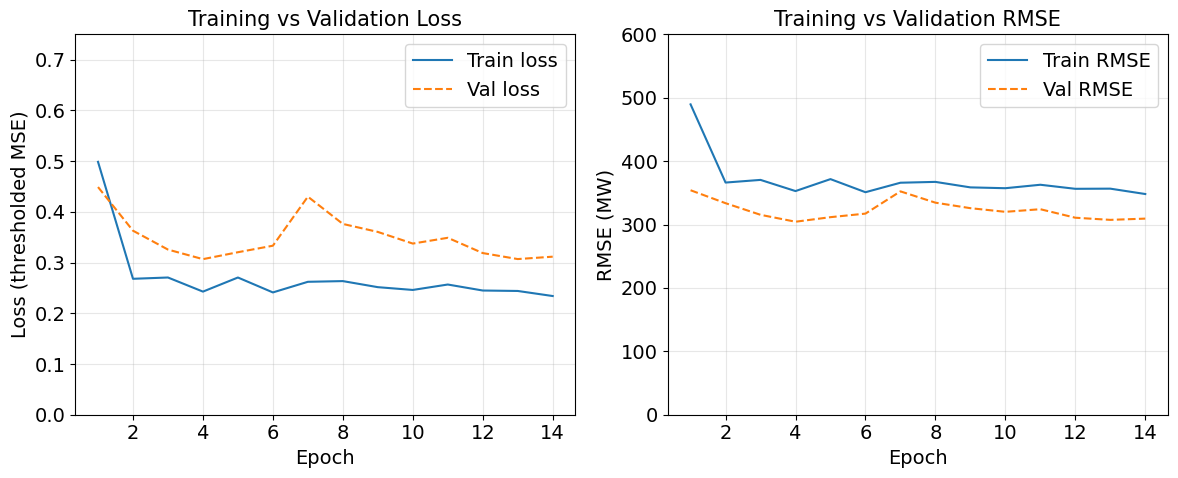

In [126]:
hist = history.history

epochs = range(1, len(hist["loss"]) + 1)

plt.figure(figsize=(12,5))

# --- Loss ---
plt.subplot(1,2,1)
plt.plot(epochs, hist["loss"], label="Train loss")
plt.plot(epochs, hist["val_loss"], label="Val loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss (thresholded MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0,0.75])

# --- RMSE ---
plt.subplot(1,2,2)
plt.plot(epochs, hist["rmse_wt"], label="Train RMSE")
plt.plot(epochs, hist["val_rmse_wt"], label="Val RMSE", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("RMSE (MW)")
plt.title("Training vs Validation RMSE")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([000,600])

plt.tight_layout()
plt.show()

In [68]:
model.save('pv_forecasting_model.keras')